In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import gamma

In [2]:
class CSO:

    def __init__(self, fitness, P=150, n=2, pa=0.25, beta=1.5, bound=None,
                plot=False, min=True, verbose=False, Tmax=300):

        '''

        PARAMETERS:

        fitness: A FUNCTION WHICH EVALUATES COST (OR THE FITNESS) VALUE

        P: POPULATION SIZE

        n: TOTAL DIMENSIONS

        pa: ASSIGNED PROBABILITY

        beta: LEVY PARAMETER

        bound: AXIS BOUND FOR EACH DIMENSION

        X: PARTICLE POSITION OF SHAPE (P,n)

        ################ EXAMPLE #####################

        If ith egg Xi = [x,y,z], n = 3, and if
        bound = [(-5,5),(-1,1),(0,5)]
        Then, x∈(-5,5); y∈(-1,1); z∈(0,5)

        ##############################################

        Tmax: MAXIMUM ITERATION

        best: GLOBAL BEST POSITION OF SHAPE (n,1)

        '''
        self.fitness = fitness
        self.P = P
        self.n = n
        self.Tmax = Tmax
        self.pa = pa
        self.beta = beta
        self.bound = bound
        self.plot = plot
        self.min = min
        self.verbose = verbose

        # X = (U-L)*rand + L (U AND L ARE UPPER AND LOWER BOUND OF X)
        # U AND L VARY BASED ON THE DIFFERENT DIMENSION OF X

        self.X = []

        if bound is not None:
            for (U, L) in bound:
                x = (U-L)*np.random.rand(P,) + L
                self.X.append(x)
            self.X = np.array(self.X).T
        else:
            self.X = np.random.randn(P,n)

    def update_position_1(self):

        '''

        ACTION:

        TO CALCULATE THE CHANGE OF POSITION 'X = X + rand*C' USING LEVY FLIGHT METHOD

        C = 0.01*S*(X-best) WHERE S IS THE RANDOM STEP, and β = beta (TAKEN FROM [1])

              u
        S = -----
                1/β
             |v|

        beta = 1.5

        u ~ N(0,σu) # NORMAL DISTRIBUTION WITH ZERO MEAN AND 'σu' STANDARD DEVIATION

        v ~ N(0,σv) # NORMAL DISTRIBUTION WITH ZERO MEAN AND 'σv' STANDARD DEVIATION

        σv = 1

                     Γ(1+β)*sin(πβ/2)
        σu^β = --------------------------
                   Γ((1+β)/2)*β*(2^((β-1)/2))

        Γ IS THE GAMMA FUNCTION

        '''

        num = gamma(1+self.beta)*np.sin(np.pi*self.beta/2)
        den = gamma((1+self.beta)/2)*self.beta*(2**((self.beta-1)/2))
        σu = (num/den)**(1/self.beta)
        σv = 1
        u = np.random.normal(0, σu, self.n)
        v = np.random.normal(0, σv, self.n)
        S = u/(np.abs(v)**(1/self.beta))

        # DEFINING GLOBAL BEST SOLUTION BASED ON FITNESS VALUE

        for i in range(self.P):
            if i==0:
                self.best = self.X[i,:].copy()
            else:
                self.best = self.optimum(self.best, self.X[i,:])

        Xnew = self.X.copy()
        for i in range(self.P):
            Xnew[i,:] += np.random.randn(self.n)*0.01*S*(Xnew[i,:]-self.best)
            self.X[i,:] = self.optimum(Xnew[i,:], self.X[i,:])

    def update_position_2(self):

        '''

        ACTION:

        TO REPLACE SOME NEST WITH NEW SOLUTIONS

        HOST BIRD CAN THROW EGG AWAY (ABANDON THE NEST) WITH FRACTION

        pa ∈ [0,1] (ALSO CALLED ASSIGNED PROBABILITY) AND BUILD A COMPLETELY

        NEW NEST. FIRST WE CHOOSE A RANDOM NUMBER r ∈ [0,1] AND IF r < pa,

        THEN 'X' IS SELECTED AND MODIFIED ELSE IT IS KEPT AS IT IS.

        '''

        Xnew = self.X.copy()
        Xold = self.X.copy()
        for i in range(self.P):
            d1,d2 = np.random.randint(0,5,2)
            for j in range(self.n):
                r = np.random.rand()
                if r < self.pa:
                    Xnew[i,j] += np.random.rand()*(Xold[d1,j]-Xold[d2,j])
            self.X[i,:] = self.optimum(Xnew[i,:], self.X[i,:])

    def optimum(self, best, particle_x):

        '''

        PARAMETERS:

        best: GLOBAL BEST SOLUTION 'best'

        particle_x: PARTICLE POSITION

        ACTION:

        COMPARE PARTICLE'S CURRENT POSITION WITH GLOBAL BEST POSITION

            1. IF PROBLEM IS MINIMIZATION (min=TRUE), THEN CHECKS WHETHER FITNESS VALUE OF 'best'

            IS LESS THAN THE FITNESS VALUE OF 'particle_x' AND IF IT IS GREATER, THEN IT

            SUBSTITUTES THE CURRENT PARTICLE POSITION AS THE BEST (GLOBAL) SOLUTION

            2. IF PROBLEM IS MAXIMIZATION (min=FALSE), THEN CHECKS WHETHER FITNESS VALUE OF 'best'

            IS GREATER THAN THE FITNESS VALUE OF 'particle_x' AND IF IT IS LESS, THEN IT

            SUBSTITUTES THE CURRENT PARTICLE POSITION AS THE BEST (GLOBAL) SOLUTION

        '''
        if self.min:
            if self.fitness(best) > self.fitness(particle_x):
                best = particle_x.copy()
        else:
            if self.fitness(best) < self.fitness(particle_x):
                best = particle_x.copy()
        return best

    def clip_X(self):

        # IF BOUND IS SPECIFIED THEN CLIP 'X' VALUES SO THAT THEY ARE IN THE SPECIFIED RANGE

        if self.bound is not None:
            for i in range(self.n):
                xmin, xmax = self.bound[i]
                self.X[:,i] = np.clip(self.X[:,i], xmin, xmax)

    def execute(self):

        '''

        PARAMETERS:

        t: ITERATION NUMBER

        fitness_time: LIST STORING FITNESS (OR COST) VALUE FOR EACH ITERATION

        time: LIST STORING ITERATION NUMBER ([0,1,2,...])

        ACTION:

        AS THE NAME SUGGESTS, THIS FUNCTION EXECUTES CUCKOO SEARCH ALGORITHM

        BASED ON THE TYPE OF PROBLEM (MAXIMIZATION OR MINIMIZATION).

        NOTE: THIS FUNCTION PRINTS THE GLOBAL FITNESS VALUE FOR EACH ITERATION

        IF THE VERBOSE IS TRUE

        '''

        self.fitness_time, self.time = [], []

        for t in range(self.Tmax):
            self.update_position_1()
            self.clip_X()
            self.update_position_2()
            self.clip_X()
            self.fitness_time.append(self.fitness(self.best))
            self.time.append(t)
            if self.verbose:
                print('Iteration:  ',t,'| best global fitness (cost):',round(self.fitness(self.best),7))

        print('\nOPTIMUM SOLUTION\n  >', np.round(self.best.reshape(-1),7).tolist())
        print('\nOPTIMUM FITNESS\n  >', np.round(self.fitness(self.best),7))
        print()
        if self.plot:
            self.Fplot()

    def Fplot(self):

        # PLOTS GLOBAL FITNESS (OR COST) VALUE VS ITERATION GRAPH

        plt.plot(self.time, self.fitness_time)
        plt.title('Fitness value vs Iteration')
        plt.xlabel('Iteration')
        plt.ylabel('Fitness value')
        plt.show()

In [13]:
def fitness_1(X):

    '''

    X: POSITION (EITHER CURRENT, LOCAL BEST OR GLOBAL BEST) OF SIZE (n,)

    2-DIMENSIONAL VECTORS (X = (x,y))

    #################################################################################

    HIMMELBLAU'S FUNCTION

    MINIMIZE f(x) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2

    OPTIMUM SOLUTION IS x* = 3 AND y* = 2

    REPLACE 'f' BELOW WITH THIS TO TEST EXAMPLE-1

    f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2

    '''
    X = np.array(X).reshape(-1,1)
    x, y = X[0][0], X[1][0]
    f = (x**2 + y - 11)**2 + (x + y**2 - 7)**2
    return f


OPTIMUM SOLUTION
  > [2.9999989, 2.0000026]

OPTIMUM FITNESS
  > 0.0



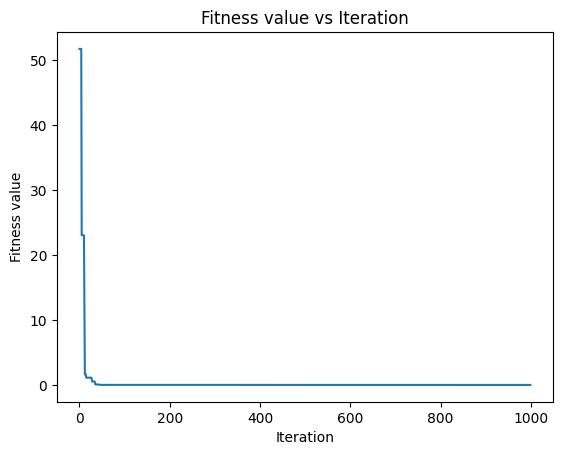

In [18]:
CSO(fitness=fitness_1, n=2,P=10,bound=[(-6,6),(-6,6)],Tmax=1000,plot=True).execute()